In [38]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
from matplotlib import animation
import seaborn as sns

# QLearning

In [39]:
def run_animation(experience_buffer):
    """Function to run animation"""
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        # Print console output
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")

        # Pauze animation
        sleep(time_lag)

In [40]:
def store_episode_as_gif(experience_buffer, path='./', filename='animation2.gif'):
    """Store episode as gif animation"""
    fps = 5   # Set framew per seconds
    dpi = 30  # Set dots per inch
    interval = 50  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Fix frame size
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Save output as gif
    anim.save(path + filename, writer='imagemagick', fps=fps)

State space: Discrete(500)
Action space: Discrete(6)
State: 269
Action: 0
Action mask: [1 1 1 1 0 0]
Reward: -1


c:\Users\Junior Quintana\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


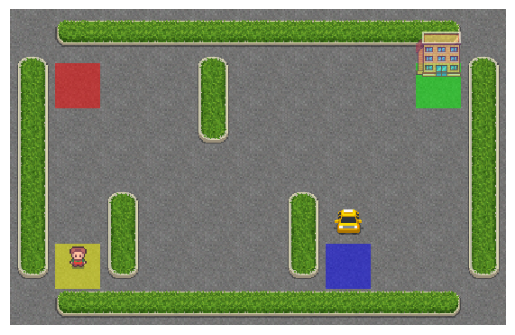

In [47]:
"""Initialize and validate the environment"""
env = gym.make("Taxi-v3", render_mode="rgb_array").env
state, information = env.reset()

# Print dimensions of state and action space
print("State space: {}".format(env.observation_space))
print("Action space: {}".format(env.action_space))

# Sample random action
action = env.action_space.sample(env.action_mask(state))
next_state, reward, done, truncated, info = env.step(action)

# Print output
print("State: {}".format(state))
print("Action: {}".format(action))
print("Action mask: {}".format(env.action_mask(state)))
print("Reward: {}".format(reward))

# Render and plot an environment frame
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

Episode #: 10000


===Training completed.===



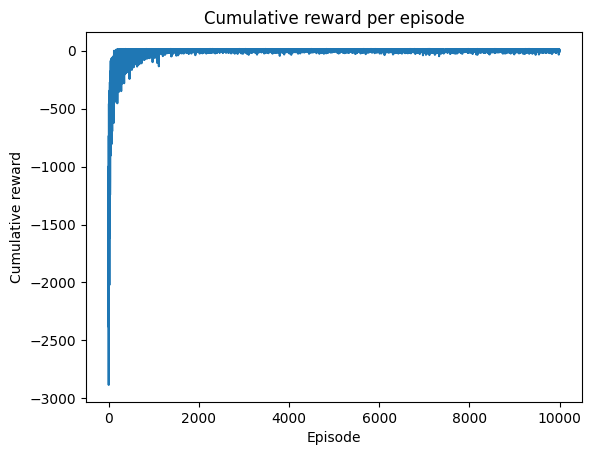

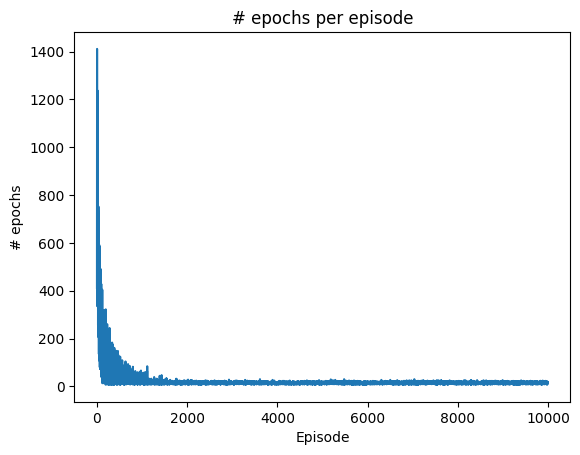

CPU times: total: 9.03 s
Wall time: 10 s


In [42]:
%%time 

"""Training the agent"""
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 1.0  # Discount rate
epsilon = 0.1  # Exploration rate
num_episodes = 10000  # Number of episodes

# Output for plots
cum_rewards = np.zeros([num_episodes])
total_epochs = np.zeros([num_episodes])

for episode in range(1, num_episodes+1):
    # Reset environment
    state, info = env.reset()
    epoch = 0 
    num_failed_dropoffs = 0
    done = False
    cum_reward = 0

    while not done:
        
        if random.uniform(0, 1) < epsilon:
            "Basic exploration"
            action = env.action_space.sample() # Sample random action (exploration)
            
            "Exploration with action mask"
          # action = env.action_space.sample(env.action_mask(state)) "Exploration with action mask"
        else:
            "Exploitation with random tie breaker"
          #  action = np.random.choice(np.flatnonzero(q_table[state] == q_table[state].max()))
            
            "Basic exploitation"
            action = np.argmax(q_table[state]) # Select best known action (exploitation)
 
        next_state, reward, done, _ , info = env.step(action) 

        cum_reward += reward
        
        old_q_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)
        
        q_table[state, action] = new_q_value
        
        if reward == -10:
            num_failed_dropoffs += 1

        state = next_state
        epoch += 1
        
        total_epochs[episode-1] = epoch
        cum_rewards[episode-1] = cum_reward

    if episode % 100 == 0:
        clear_output(wait=True)
        print(f"Episode #: {episode}")

print("\n")
print("===Training completed.===\n")

# Plot reward convergence
plt.title("Cumulative reward per episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.plot(cum_rewards)
plt.show()

# Plot epoch convergence
plt.title("# epochs per episode")
plt.xlabel("Episode")
plt.ylabel("# epochs")
plt.plot(total_epochs)
plt.show()

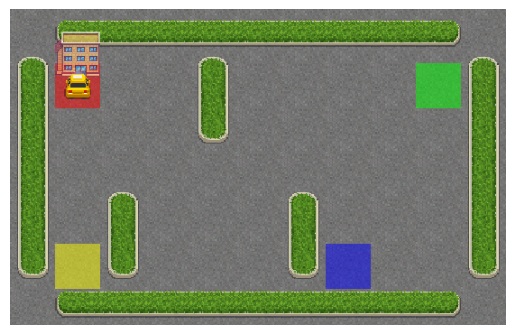

Episode: 10/10
Epoch: 6/6
State: 0
Action: 5
Reward: 15


Test results after 10 episodes:
Mean # epochs per episode: 13.9
Mean # failed drop-offs per episode: 0.0


In [46]:
"""Test policy performance after training"""

num_epochs = 0
total_failed_deliveries = 0
num_episodes = 10
experience_buffer = []
store_gif = True

for episode in range(1, num_episodes+1):
    # Initialize experience buffer

    my_env = env.reset()
    state = my_env[0]
    epoch = 1 
    num_failed_deliveries =0
    cum_reward = 0
    done = False

    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, truncated, info = env.step(action)
        cum_reward += reward

        if reward == -10:
            num_failed_deliveries += 1

        # Store rendered frame in animation dictionary
        experience_buffer.append({
            'frame': env.render(),
            'episode': episode,
            'epoch': epoch,
            'state': state,
            'action': action,
            'reward': cum_reward
            }
        )

        epoch += 1

    total_failed_deliveries += num_failed_deliveries
    num_epochs += epoch

    if store_gif:
        store_episode_as_gif(experience_buffer)

# Run animation and print output
run_animation(experience_buffer)

# Print final results
print("\n") 
print(f"Test results after {num_episodes} episodes:")
print(f"Mean # epochs per episode: {num_epochs / num_episodes}")
print(f"Mean # failed drop-offs per episode: {total_failed_deliveries / num_episodes}")

# Policy and Value Iteration

In [11]:
env = gym.make('Taxi-v3')
random_policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n
def random_policy_steps_count():
    state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, truncated, info = env.step(env.action_space.sample())  
        counter += 1
    return counter

C:\Users\Junior Quintana\AppData\Local\Temp\ipykernel_12704\662570549.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(counts)


Text(0.5, 1.0, 'Distribution of number of steps needed')

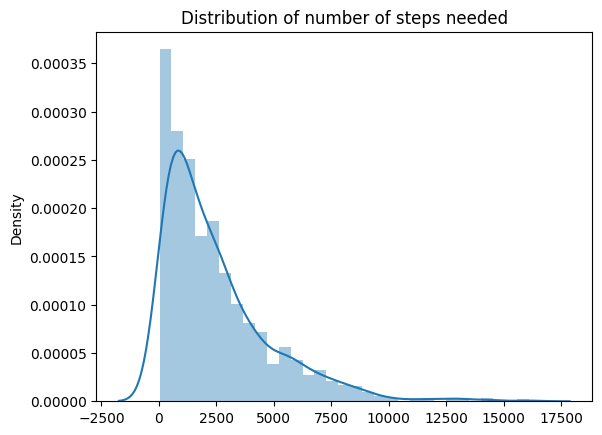

In [17]:
counts = [random_policy_steps_count() for i in range(1000)]
sns.distplot(counts)
plt.title("Distribution of number of steps needed")

In [18]:
print("An agent using Random search takes about an average of " + str(int(np.mean(counts)))
      + " steps to successfully complete its mission.")

An agent using Random search takes about an average of 2486 steps to successfully complete its mission.


In [20]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    # Start with a random (all 0) value function
    V = np.zeros(env.observation_space.n)
    while True:
        # TODO: Implement!
        delta = 0  #delta = change in value of state from one iteration to next
       
        for state in range(env.observation_space.n):  #for all states
            val = 0  #initiate value as 0
                     
            for action,act_prob in enumerate(policy[state]): #for all actions/action probabilities
                for prob,next_state,reward,done in env.P[state][action]:  #transition probabilities,state,rewards of each action
                    val += act_prob * prob * (reward + discount_factor * V[next_state])  #eqn to calculate
            delta = max(delta, np.abs(val-V[state]))
            V[state] = val
        if delta < theta:  #break if the change in value is less than the threshold (theta)
            break
    return np.array(V)

def policy_iteration(env, policy_eval_fn=policy_eval, discount_factor=1.0):

    # Start with a random policy
    policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n

    while True:
        # Implement this!
        curr_pol_val = policy_eval_fn(policy, env, discount_factor)  #eval current policy
        policy_stable = True  #Check if policy did improve (Set it as True first)
        for state in range(env.observation_space.n):  #for each states
            chosen_act = np.argmax(policy[state])  #best action (Highest prob) under current policy
            act_values = one_step_lookahead(state,curr_pol_val, discount_factor)  #use one step lookahead to find action values
            best_act = np.argmax(act_values) #find best action
            if chosen_act != best_act:
                policy_stable = False  #Greedily find best action
            policy[state] = np.eye(env.action_space.n)[best_act]  #update 
        if policy_stable:
            return policy, curr_pol_val
        
    return policy, np.zeros(env.observation_space.n)

def value_iteration(env, theta=0.0001, discount_factor=1.0):
    
    V = np.zeros(env.observation_space.n)

    while True:
        delta = 0  #checker for improvements across states
        for state in range(env.observation_space.n):
            act_values = one_step_lookahead(state,V,discount_factor)  #lookahead one step
            best_act_value = np.max(act_values) #get best action value
            
            delta = max(delta,np.abs(best_act_value - V[state]))  #find max delta across all states
            V[state] = best_act_value  #update value to best action value
        if delta < theta:  #if max improvement less than threshold
            break
    policy = np.zeros([env.observation_space.n, env.action_space.n])

    for state in range(env.observation_space.n):  #for all states, create deterministic policy
        act_val = one_step_lookahead(state,V,discount_factor)
        best_action = np.argmax(act_val)
        policy[state][best_action] = 1
        
    return policy, V



def one_step_lookahead(state, V, discount_factor):
    A = np.zeros(env.action_space.n)
    for a in range(env.action_space.n):
        for prob, next_state, reward, done in env.P[state][a]:
            A[a] += prob * (reward + discount_factor * V[next_state])
    return A

In [21]:
env = gym.make('Taxi-v3')
random_policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n
policy_eval(random_policy,env,discount_factor=0.95)

array([-66.26438752, -71.80792647, -71.42078771, -71.82385699,
       -79.85874125, -79.76644406, -79.85914609, -79.85320521,
       -78.94845049, -78.98965515, -78.18067178, -78.9907127 ,
       -79.89007096, -79.88569714, -79.8903011 , -79.81473063,
       -58.97388718, -71.28332886, -70.42368566, -71.3187026 ,
       -71.76849805, -75.09061994, -74.85861632, -75.10016676,
       -79.84505188, -79.74379722, -79.84549601, -79.83897851,
       -79.0763058 , -79.11250001, -78.40188794, -79.11342896,
       -79.87942213, -79.87462379, -79.87967461, -79.79676993,
       -67.0351757 , -74.29222689, -73.47645597, -74.33919453,
       -79.64432128, -79.7878237 , -79.77780243, -79.78823608,
       -77.71728288, -76.22431024, -77.72383134, -77.6277274 ,
       -79.84088218, -79.84711324, -79.72477359, -79.84727316,
       -79.40240042, -79.37859483, -79.40365295, -78.99236538,
       -76.72709833, -73.48229756, -76.82709925, -76.20673132,
       -79.71298147, -79.82877523, -79.82068901, -79.82

In [22]:
pol_iter_policy = policy_iteration(env,policy_eval,discount_factor=0.99)
pol_iter_policy[0]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [23]:
val_iter_policy = value_iteration(env,discount_factor=0.99)
val_iter_policy[0]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [24]:
for x in range(len(pol_iter_policy[0])):
    if not (pol_iter_policy[0][x] == val_iter_policy[0][x]).all():
        print("Not the same Policy")
        break
print("Same Policy")

Same Policy


In [30]:
def count(policy):
    curr_state, information = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, truncated, info = env.step(np.argmax(policy[curr_state]))  
        curr_state = state
        counter += 1
    return counter

An agent using a policy which has been improved using policy-iterated takes about an average of 13 steps to successfully complete its mission.


C:\Users\Junior Quintana\AppData\Local\Temp\ipykernel_12704\3565707692.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pol_counts)


<AxesSubplot: ylabel='Density'>

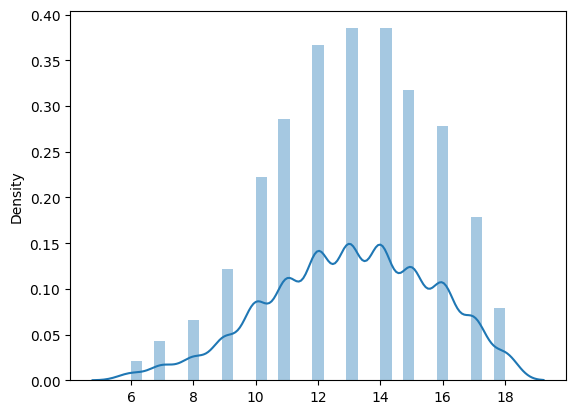

In [33]:
pol_count = count(pol_iter_policy[0])
pol_counts = [count(pol_iter_policy[0]) for i in range(10000)]
print("An agent using a policy which has been improved using policy-iterated takes about an average of " + str(int(np.mean(pol_counts)))
      + " steps to successfully complete its mission.")
sns.distplot(pol_counts)

An agent using a policy which has been value-iterated takes about an average of 13 steps to successfully complete its mission.


C:\Users\Junior Quintana\AppData\Local\Temp\ipykernel_12704\4184611611.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(val_counts)


<AxesSubplot: ylabel='Density'>

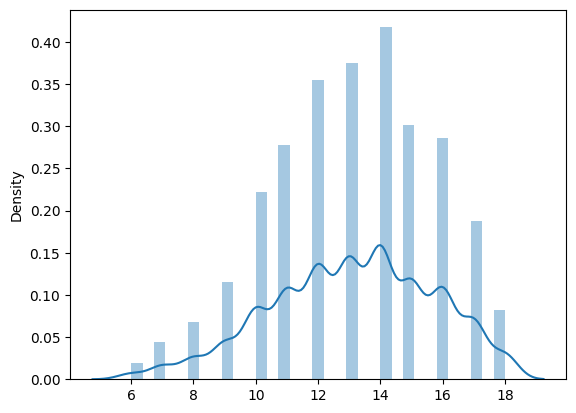

In [34]:
val_count = count(val_iter_policy[0])
val_counts = [count(val_iter_policy[0]) for i in range(10000)]
print("An agent using a policy which has been value-iterated takes about an average of " + str(int(np.mean(val_counts)))
      + " steps to successfully complete its mission.")
sns.distplot(val_counts)